In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: talhanaveed00
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced


100%|██████████| 1.90G/1.90G [00:07<00:00, 276MB/s]


In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import shap

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [16]:
# Loading Dataset
train_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [17]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=5, ignore_mismatched_sizes=True
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-18-39165d37fbef>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [19]:
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = correct / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Train Accuracy: {train_acc:.4f}")
        print(f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}")
        test(model, val_loader)

In [20]:
def test(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images).logits
            predictions = outputs.argmax(1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    visualize_gradcam(model, val_loader)

In [21]:
# Grad-CAM Visualization
def visualize_gradcam(model, dataloader):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    model.eval()
    outputs = model(images).logits
    predictions = outputs.argmax(1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {predictions[i].item()}, Actual: {labels[i].item()}")
        axes[i].axis("off")
    plt.show()

In [22]:
def shap_explain(model, dataloader):
    model.eval()
    batch = next(iter(dataloader))[0][:10].to(device)
    explainer = shap.GradientExplainer(model, batch)
    shap_values = explainer.shap_values(batch)
    shap.image_plot(shap_values, batch.cpu().numpy())

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1, Loss: 0.9670959589455057, Train Accuracy: 0.5830
Precision: 0.5864, Recall: 0.5830, F1-score: 0.5832
Test Accuracy: 0.6516
Precision: 0.6543, Recall: 0.6516, F1-score: 0.6513


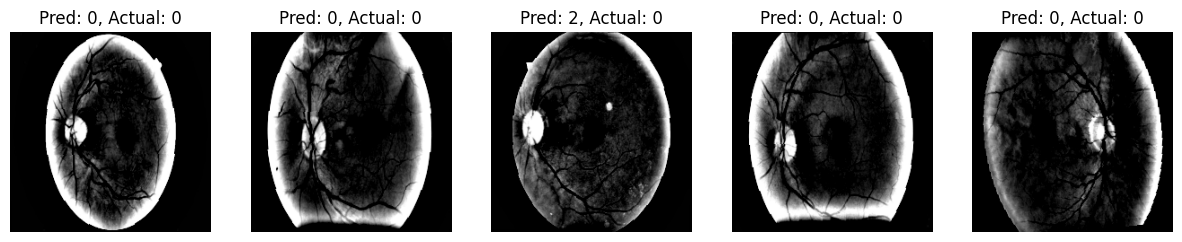

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2, Loss: 0.763615707099876, Train Accuracy: 0.6754
Precision: 0.6796, Recall: 0.6754, F1-score: 0.6765
Test Accuracy: 0.6916
Precision: 0.6988, Recall: 0.6916, F1-score: 0.6909


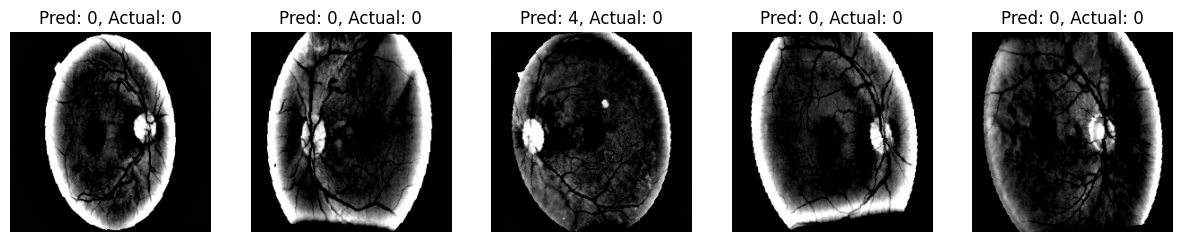

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3, Loss: 0.6242855842608739, Train Accuracy: 0.7329
Precision: 0.7357, Recall: 0.7329, F1-score: 0.7336
Test Accuracy: 0.7092
Precision: 0.7030, Recall: 0.7092, F1-score: 0.7043


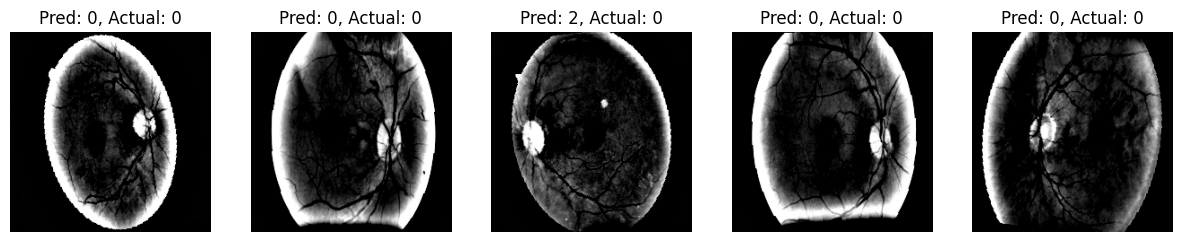

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4, Loss: 0.5229229049428421, Train Accuracy: 0.7783
Precision: 0.7806, Recall: 0.7783, F1-score: 0.7788
Test Accuracy: 0.7309
Precision: 0.7460, Recall: 0.7309, F1-score: 0.7249


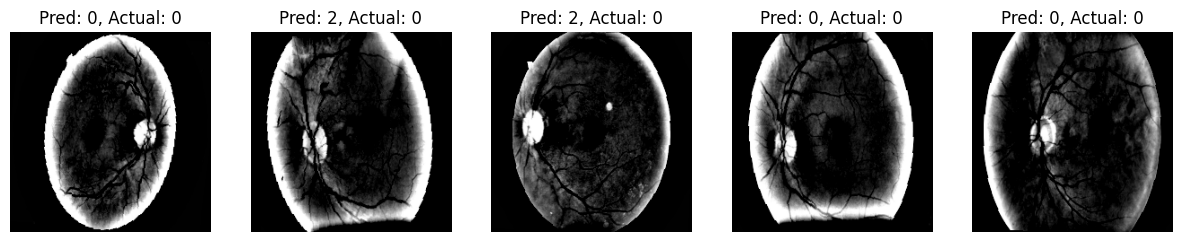

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5, Loss: 0.431841429487309, Train Accuracy: 0.8185
Precision: 0.8203, Recall: 0.8185, F1-score: 0.8190
Test Accuracy: 0.7591
Precision: 0.7617, Recall: 0.7591, F1-score: 0.7549


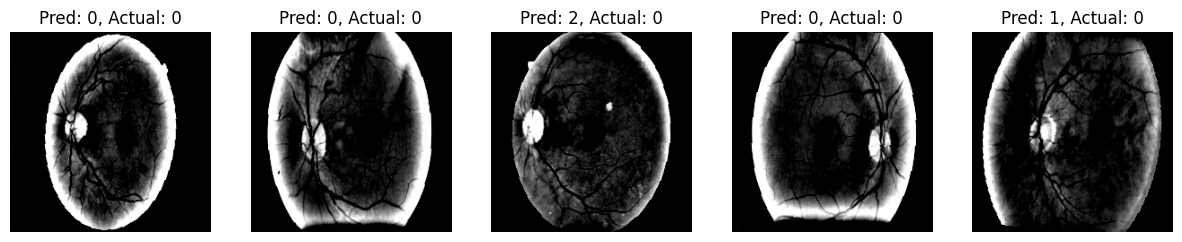

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6, Loss: 0.3555698511738549, Train Accuracy: 0.8545
Precision: 0.8557, Recall: 0.8545, F1-score: 0.8548
Test Accuracy: 0.7869
Precision: 0.7878, Recall: 0.7869, F1-score: 0.7840


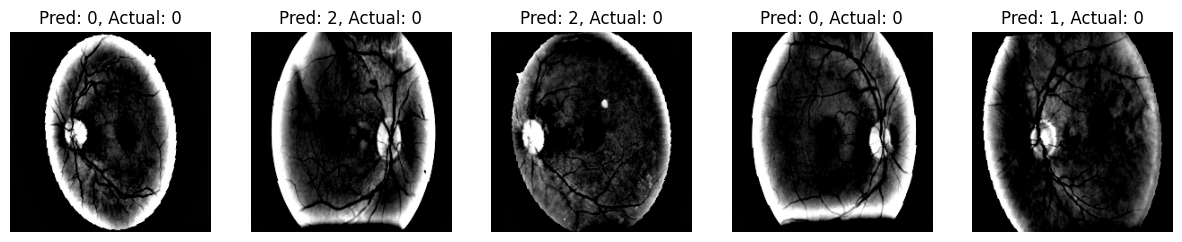

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7, Loss: 0.27797077587970037, Train Accuracy: 0.8893
Precision: 0.8898, Recall: 0.8893, F1-score: 0.8895
Test Accuracy: 0.8010
Precision: 0.8017, Recall: 0.8010, F1-score: 0.8007


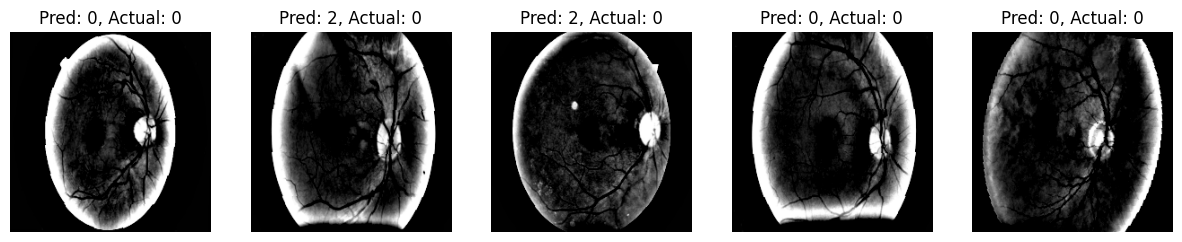

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8, Loss: 0.21783828149166176, Train Accuracy: 0.9156
Precision: 0.9159, Recall: 0.9156, F1-score: 0.9157
Test Accuracy: 0.8115
Precision: 0.8126, Recall: 0.8115, F1-score: 0.8099


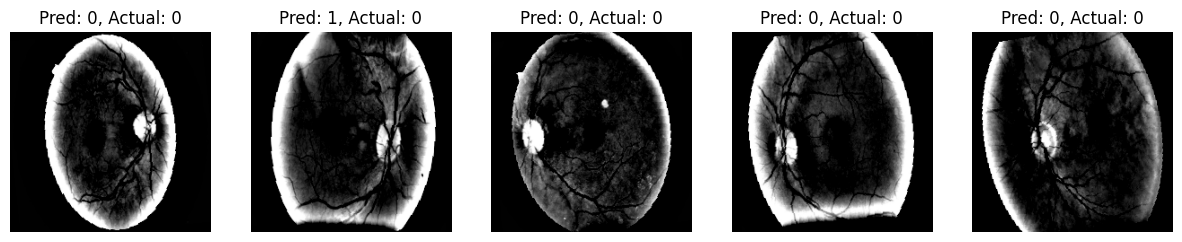

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9, Loss: 0.17146886301035172, Train Accuracy: 0.9345
Precision: 0.9347, Recall: 0.9345, F1-score: 0.9346
Test Accuracy: 0.8265
Precision: 0.8246, Recall: 0.8265, F1-score: 0.8231


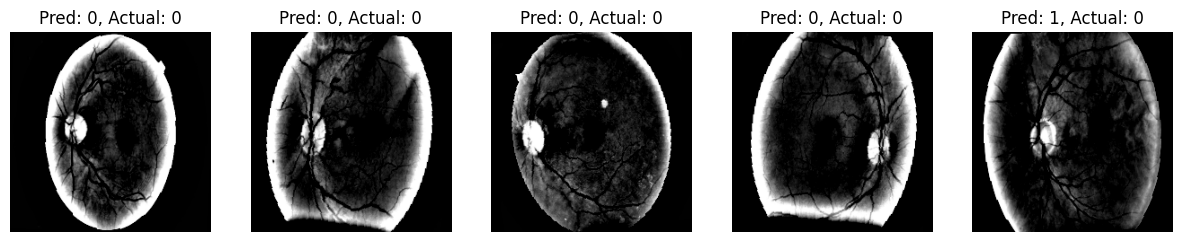

<ipython-input-19-76b6a7b2b59f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10, Loss: 0.1337589026935508, Train Accuracy: 0.9494
Precision: 0.9494, Recall: 0.9494, F1-score: 0.9494
Test Accuracy: 0.8394
Precision: 0.8440, Recall: 0.8394, F1-score: 0.8407


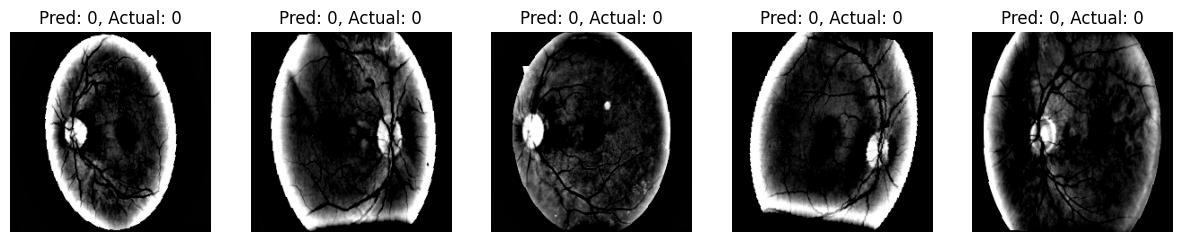

In [23]:
train(model, train_loader, val_loader, epochs=10)